# Practice Session 03: Find near-duplicates using shingling

Author: <font color="blue">Àlex Montoya Pérez</font>

E-mail: <font color="blue">alex.montoya01@estudiant.upf.edu</font>

Date: <font color="blue">10/10/2023</font>

# **Google Colaboratory Setup**

In order to develop this laboratory, I used Google Colaboratory, since I have worked with different files I had to set up the environment as follows:


1.   Importing the drive module from the google.colab package.
2.   Mounting the Google Drive at the specified path (/content/drive).
3.   Changing the current working directory to the directory where I have all needed data /content/drive/MyDrive/MineriaDadesMasives/Labs/.

Verify that we are in the correct directory:


4.   Printing the current working directory path using !pwd.
5.   Listing the contents of the current directory using !ls.

In [29]:
from google.colab import drive
drive.mount('/content/drive')
#Here is how to change current working directory
#By default the current working directory is /content
%cd /content/drive/MyDrive/MineriaDadesMasives/Labs/
#Print path and content of the current directory
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MineriaDadesMasives/Labs
/content/drive/MyDrive/MineriaDadesMasives/Labs
data				       ps04_association_rules.ipynb	ps08_data_streams.ipynb
old				       ps05_content_based_recsys.ipynb	ps09_forecasting.ipynb
ps01_02_data_preparation_242873.ipynb  ps06_item_based_recsys.ipynb	README.md
ps03_near_duplicates.ipynb	       ps07_outlier_analysis.ipynb


In [30]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [31]:
# Input file
INPUT_FILENAME = "data/covid-lockdown-catalonia/CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:

    messages_read = 0
    for line in input_file:

        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":

            messages_read += 1

            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions
---

## JACARD SIMILARITY


In [32]:
def jaccard_similarity(set1, set2):
    #First of all, we declare set to what enters to function to avoid errors.
    set1 = set(set1)
    set2 = set(set2)
    # Apply the formula intersection/union using the functions .intersection and .union
    nominator = set1.intersection(set2)
    denominator = set1.union(set2)

    #To avoid the case where the denominator = 0, we return a 0 instead.
    if(len(denominator) == 0):
        return 0

    # Otherwise, we'll return the value of jaccard similarity
    similarity = len(nominator)/len(denominator)
    return similarity

### Test cases

In [33]:
## Two arrays for which the jaccard similarity is 0.6666...
A = {1, 2, 4, 8, 7}
B = {1, 2, 4, 8, 9}
print("First case: ")
print(jaccard_similarity(A,B))

## Two arrays for which the jaccard similarity is 0.75
A = {1, 2, 3, 4}
B = {1, 2, 3}
print("\nSecond case: ")
print(jaccard_similarity(A,B))

## Two arrays for which the jaccard similarity is 1.0
A = {1, 2, 4, 8, 9}
B = {1, 2, 4, 8, 9}
print("\nThird case: ")
print(jaccard_similarity(A,B))

## Two empty arrays should have jaccard similarity 0.0
A = set()
B = set()
print("\nFourth case: ")
print(jaccard_similarity(A,B))

First case: 
0.6666666666666666

Second case: 
0.75

Third case: 
1.0

Fourth case: 
0


## FUNCTION CLEAN


In [34]:
#Using "re" library, we clean the text as follows:

def clean(text):

    #Removing "RT " prefixes from the tweets
    text = re.sub('RT ', '', text)

    #Once we removed all the RT , we can transform all upercase letters to lowercase to remove the other ones
    text = text.lower()

    #Romanizing text, replacing "Ñ" by "n", "ñ" by "n", "ó" by "o", "à" by "a", "l·l" by "ll", and so on.
    text = re.sub('Ñ', 'n', text)
    text = re.sub('ñ', 'n', text)
    text = re.sub('é', 'e', text)
    text = re.sub('è', 'e', text)
    text = re.sub('ò', 'o', text)
    text = re.sub('ú', 'u', text)
    text = re.sub('ç', 'c', text)
    text = re.sub('í', 'i', text)
    text = re.sub('ó', 'o', text)
    text = re.sub('à', 'a', text)
    text = re.sub('l·l', 'll', text)

    #Removing URLs, both "http" and "https" ones.
    text = re.sub(r'\S*https?:\S*', '', text)

    # Removing spaces at the beginning and spaces at the end with the strip() function.
    text.strip()

    # Removing anything that remains that is not a letter or digit
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)

    # Changing double spaces to single spaces.
    text = re.sub(" +", " ", text)
    return text

### Test cases


In [35]:
#We do some tests to know whether the function is working correctly or not.

# RT Test
print ("RT Test: ")
text1 = "RT dawdjad"
print(" Original text --> ",text1)
text1 = clean( text1)
print(" Cleaned text --> ",text1)

# Romanizing Test
print ("\nRomanizing Test: ")
text2 = " l·lZúñçÑóáì´q "
print(" Original text --> ", text2)
text2 = clean(text2)
print(" Cleaned text --> ", text2)

# Removing URL's Test
print ("\nRemoving URL's Test: ")
text3 = "https://es.wikipedia.org/wiki/Lionel_Messi Messi"
print(" Original text --> ", text3)
text3 = clean(text3)
print(" Cleaned text --> ",text3)

#Special Characters Test
print ("\nSpecial Characters Test: ")
text4 = "fdawda&&Sss$$"
print(" Original text --> ", text4)
text4 = clean(text4)
print(" Cleaned text --> ",text4)

# Double Spaces Test
print ("\nDouble Spaces Test: ")
text5 = "M                    eeessiiiiii"
print(" Original text --> ", text5)
text5 = clean(text5)
print(" Cleaned text --> ",text5)

RT Test: 
 Original text -->  RT dawdjad
 Cleaned text -->  dawdjad

Romanizing Test: 
 Original text -->   l·lZúñçÑóáì´q 
 Cleaned text -->   llzuncnoq 

Removing URL's Test: 
 Original text -->  https://es.wikipedia.org/wiki/Lionel_Messi Messi
 Cleaned text -->   messi

Special Characters Test: 
 Original text -->  fdawda&&Sss$$
 Cleaned text -->  fdawdasss

Double Spaces Test: 
 Original text -->  M                    eeessiiiiii
 Cleaned text -->  m eeessiiiiii


# 2. Implement an n-gram extractor
----

In [36]:
# Implement the function ngrams(text,size) -->  produce all sub-sequences of size words present in the text

MIN_TOKEN_LENGTH = 2 #I had to change it from 3 to 2 otherwise does not work

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []
    temp = []

    for i in range(0, len(tokens)):
        #We check all possible tokens and if they are words of more than MIN_TOKEN_LENGTH
        if(len(tokens[i]) >= MIN_TOKEN_LENGTH):
                # add the word
                temp.append(tokens[i])

    for j in range(len(temp)-size+1):
        #We convert all accepted words to ngrams of size = size so,
        # get the j:j+size words and put them as an ngram which means, separated by a space
        ngram = ' '.join(temp[j:j+size])
        # add it to ngrams list
        ngrams.append(ngram)

    return ngrams

## Testing function "ngrams"


In [37]:
print(messages[9780])
print(ngrams(messages[9780], 3))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants xinesos', 'comerciants xinesos donen', 'xinesos donen mascaretes', 'donen mascaretes gel', 'mascaretes gel antiseptic', 'gel antiseptic badalona', 'antiseptic badalona per', 'badalona per lluitar', 'per lluitar contra', 'lluitar contra el', 'contra el coronavirus']


# 3. Estimation for brute force method
---

In [38]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")

    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):

            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

## Plot Analysis

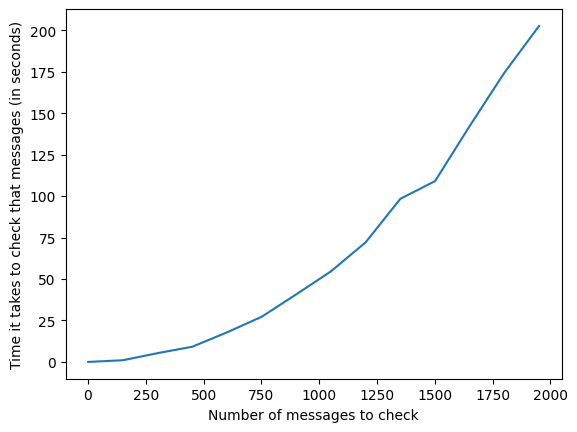

In [39]:
# plot in which you have in the x axis the number of messages to check, and in the y axis the time it takes to check that many messages if we use ngrams of size 4
# x from 1 to 2001 in increments of 150
temp = []
x_limit = 2001
x_increment = 150

# compute time to check messages with the function
for i in range(1,x_limit,x_increment):
    temp.append(time_brute_force_similarities(messages, i, 3))

#Define values of axis
y = temp
x = range(1, x_limit, x_increment)

plt.plot(x,y)
#Define the labels of the axis
plt.xlabel("Number of messages to check")
plt.ylabel("Time it takes to check that messages (in seconds)")
plt.show()

The trend is evidently exponential, indicating that the time taken for message checking increases as the number of messages grows.

When inspecting 1000 messages, it takes about 50 seconds. Extrapolating, if we were to analyze 10,000 messages (the size of the matrix), one might expect it to take roughly 500 seconds if the growth were linear. However, given the exponential pattern, it would take more time.

# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [40]:
# the dictionary ngram_to_index, which should convert an ngram to an index (a row number),
# the dictionary index_to_ngram, which should convert an index to an ngram, and
# the variable num_distinct_ngrams which should contain the number of distinct ngrams.

NGRAM_SIZE = 3 # I had to change it from 4 to 3, otherwise does not work

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        # YOUR CODE HERE
        if(ngram not in ngram_to_index):
            # Store his index in ngram_to_index with the name of ngram as a key
            ngram_to_index[ngram] = next_index
            # store the ngram with the index as a key in index_to_ngram.
            index_to_ngram[next_index] = ngram
            #  increment the index
            next_index = next_index + 1
num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 67077 distinct ngrams in the 10000 documents


## Testing the ngram_to_index structure.

In [41]:
#Used this cell to test the resultant dictionaries were correct.
string_1 = "tancat escoles fins"
string_2 = "garantir la seguretat"

# CASE 1
index_1 = ngram_to_index[string_1]
print(ngram_to_index[string_1])
print(index_to_ngram[index_1])

# CASE 2
index_2 = ngram_to_index[string_2]
print(ngram_to_index[string_2])
print(index_to_ngram[index_2])

939
tancat escoles fins
34
garantir la seguretat


## 4.2 Create table ngrams x documents

In [42]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 67077 rows (distinct shingles) x 10000 columns (distinct documents)


In [43]:
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        # replace this comment with your code
        #We get the index of the ngram to know where it is on M_ngram_doc
        i = ngram_to_index[ngram]
        #Then in position i(ngram position) docid(id of the doc, its position in matrix) we put a True value.
        M_ngram_doc[i, docid] = True

## Density of the matrix

In [44]:
#  nonzero(Trues) of the matrix with numpy function count_nonzero().
nonzero = np.count_nonzero(M_ngram_doc)

# Number of cells will be M*N of the matrix
n_cells = M_ngram_doc.shape[0]*M_ngram_doc.shape[1]

# Density of the matrix
print("M_ngram_doc matrix density is: ", nonzero/n_cells*100 , "%")

M_ngram_doc matrix density is:  0.023286968707604692 %


## Printing rows 9602 and 941 of the M_ngram_doc matrix.

In [45]:
data_col_9602 = []
data_col_941 = []

# doc 9602
for i in range(len(M_ngram_doc[:,9602])):
    #We search all the ngrams in doc 9602 which means a True value in matrix M_ngram_doc
    if(M_ngram_doc[i,9602])>0:
        #If the ngram is in doc, add it to col9602 list which will contain all the ngrams of the doc
        data_col_9602.append(str(i) + ' (' + str(index_to_ngram[i]) + ')')

print("Clean message doc 9602:", clean(messages[9602]))
print("\nNon-zeros in row 9602 of M_ngram_doc is:\n\n ", data_col_9602, "\n")

# doc 941 (same idea)
for i in range(len(M_ngram_doc[:,941])):
    if(M_ngram_doc[i,941])>0:
        data_col_941.append(str(i) + ' (' + str(index_to_ngram[i]) + ')')

print("Clean message doc 941:", clean(messages[941]))
print("\nNon-zeros in row 941 of M_ngram_doc is:\n\n ", data_col_941)

Clean message doc 9602: emergenciescat que puc fer i que no faqs del coronavirus a 14 de marc si us plau demanem difusio 

Non-zeros in row 9602 of M_ngram_doc is:

  ['911 (si us plau)', '1222 (emergenciescat que puc)', '1223 (que puc fer)', '1224 (puc fer que)', '1225 (fer que no)', '2574 (14 de marc)', '39144 (que no faqs)', '39145 (no faqs del)', '39146 (faqs del coronavirus)', '39147 (del coronavirus 14)', '39148 (coronavirus 14 de)', '39149 (de marc si)', '39150 (marc si us)', '39151 (us plau demanem)', '39152 (plau demanem difusio)'] 

Clean message doc 941: hospiolot usem de forma responsable els recursos sanitaris061 urgencies per coronavirus i sanitaries012 consultes general

Non-zeros in row 941 of M_ngram_doc is:

  ['1476 (usem de forma)', '1477 (de forma responsable)', '1478 (forma responsable els)', '1479 (responsable els recursos)', '1480 (els recursos sanitaris061)', '1481 (recursos sanitaris061 urgencies)', '1482 (sanitaris061 urgencies per)', '1483 (urgencies per cor

# 3. Implement a permutation generator

## Random Permutation Function

In [46]:
def random_permutation(k):
    #Init sequence of possible values of the permutation
    sequence = list(range(0,k))
    # Shuffle them to create a random permutation
    random.shuffle(sequence)
    return sequence

In [47]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['3 (test3)', '1 (test1)', '4 (test4)', '5 (test5)', '2 (test2)']
['3 (beta)', '1 (alpha)', '4 (delta)', '5 (epsilon)', '2 (gamma)']

Test another permutation
['3 (test3)', '4 (test4)', '1 (test1)', '5 (test5)', '2 (test2)']
['3 (beta)', '4 (delta)', '1 (alpha)', '5 (epsilon)', '2 (gamma)']


# 4. Compute the signature of each document

Now comes the core of the algorithm. We will create a new matrix `M_signature_doc` having a small number of rows (the *signature size*), which will be equivalent to the number of permutations we use. The number of columns will continue being the number of documents.

First, we create the permutations and store them in an array of arrays named `permutations`, with the following code, which you should leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [48]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))

# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 15775, 7390, 11044, ...
Permutation 1: 2241, 14106, 12427, ...
Permutation 2: 22612, 4575, 10544, ...
Permutation 3: 57199, 12412, 28310, ...
Permutation 4: 35517, 6858, 43365, ...


In [49]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)
# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # replace this comment with your code
        M_signature_doc[permutation_num,docid]= find_first_one(docid, permutation)

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

## Checking the signatures of two documents that are near-duplicates

In [50]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))


i = 385
j = 627

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #385
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat el govern de la gencat anuncia el confinament de tot catalunyadavant lemergencia de la covid19 el missatge es clau
Ngrams        : [62, 3334, 3460, 4105, 4911, 4912, 4913, 4914, 4915, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924]
Signature     : [4918.0, 4914.0, 4105.0, 4911.0, 4918.0]

Document #627
Message       : PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa
Clean message : procicatcoronavirus el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau limitar la mobilitat ajudara a evitar la propagacio 

# 5. Compare all pairs of signatures

In [51]:
# Notes :
## similarity == 1.0 they are a full signature match,
## if two documents have 0.2 < similarity < 1.0 they are a partial signature match.
## In both cases, this may mean the documents are duplicates or near duplicates.

# number of signature matches
threshold = 50

is_possible_duplicate = {}

# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)

                # - Increase count_sig_full_matches and count_sig_partial_matches as needed
                # - Include docid2 in is_possible_duplicate if needed
                if(jaccard_similarity(signature1, signature2) == 1):
                    count_sig_full_matches+=1
                    is_possible_duplicate[docid1] = docid2 #Adding to possible duplicates of docid1, docid2.
                elif(0.2 < jaccard_similarity(signature1, signature2) and jaccard_similarity(signature1, signature2) < 1):
                    count_sig_partial_matches+=1
                    is_possible_duplicate[docid1] = docid2


        # - If the number of partial matches plus full matches exceeds a threshold
        #   print the document doc1 and indicate how many matches of each type it has
        if(count_sig_partial_matches+count_sig_full_matches > threshold):
            print(docid1,"has", count_sig_partial_matches,"sig partial matches and", count_sig_full_matches, "sig full matches")

0/10000 documents scanned
16 has 20 sig partial matches and 71 sig full matches
20 has 27 sig partial matches and 28 sig full matches
53 has 0 sig partial matches and 57 sig full matches
73 has 33 sig partial matches and 18 sig full matches
77 has 177 sig partial matches and 6 sig full matches
84 has 20 sig partial matches and 70 sig full matches
166 has 0 sig partial matches and 56 sig full matches
167 has 0 sig partial matches and 55 sig full matches
168 has 0 sig partial matches and 54 sig full matches
172 has 0 sig partial matches and 53 sig full matches
174 has 0 sig partial matches and 52 sig full matches
176 has 0 sig partial matches and 51 sig full matches
226 has 41 sig partial matches and 13 sig full matches
307 has 70 sig partial matches and 17 sig full matches
328 has 0 sig partial matches and 65 sig full matches
331 has 0 sig partial matches and 64 sig full matches
394 has 26 sig partial matches and 27 sig full matches
412 has 0 sig partial matches and 63 sig full matches


## Tweet that has a substantial number of complete matches, but few partial matches


To begin, it's evident that this tweet originates from the trusted source "emergenciescat." As a result, individuals are likely to replicate the message without alterations.

Moreover, the tweet requests dissemination, prompting users to retweet and share it.

Lastly, given its abundance of relevant keywords and its timing coinciding with the initiation of lockdown measures, many individuals seeking dependable information on this subject are likely to be drawn to it.

In [52]:
messages[5077]

'RT @emergenciescat: Què puc fer i que no? FAQs del #coronavirus a 14 de març. si us plau, demanem difusió. https://t.co/D5HNxwYjwK'

## Tweet that has a substantial number of partial matches, but fewer complete matches

The resemblance between these tweets is quite pronounced, as both focus on curbing the transmission of the coronavirus and report on the same news. Consequently, they employ identical keywords to engage the reader's interest while incorporating some distinct words to provide context for the new information. Furthermore, they both attribute the source within the tweet, contributing to their shared vocabulary. These factors collectively render these tweets highly akin and potentially duplicative.

In [53]:
messages[1257]

'Quines mesures de prevenció cal seguir per evitar la propagació del #coronavirus, segons @salutcat 👇 https://t.co/7W9gwTVaQG'

In [55]:
messages[is_possible_duplicate[1257]]

'RT @salutcat: Quines mesures de prevenció cal seguir per evitar la propagació del 🦠 #coronavirus SARS-CoV-2 👇\n\n🔗 https://t.co/NS41dWDi9O ht…'

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>